In [ ]:
# Preflight non-destructif — exécute tel quel et colle la sortie ici
import json, hashlib, sys, os, subprocess
from pathlib import Path
from datetime import datetime

# Paramètres (ne pas modifier) : chemins relatifs au repo / notebook cwd
cwd = Path.cwd()
results_dir = cwd / "results" / "ds_remove_small_lambda"
wide_name = "theilsen_ds_remove_small_lambda_wide.csv"
perb_name = "theilsen_ds_remove_small_lambda_per_b.csv"
diag_dir = cwd / "diagnostics_theilsen_per_b"

def sha1_of(p):
    try:
        h = hashlib.sha1()
        with open(p, "rb") as fh:
            while True:
                b = fh.read(8192)
                if not b: break
                h.update(b)
        return h.hexdigest()
    except Exception as e:
        return None

print("Preflight run at:", datetime.utcnow().isoformat() + "Z")
print("Working dir:", str(cwd))
print("Expected results dir:", str(results_dir))

# existence checks
wide_fp = results_dir / wide_name
perb_fp = results_dir / perb_name

print("\nFiles existence:")
for p in (wide_fp, perb_fp):
    print("-", p.name, "->", "FOUND" if p.exists() else "MISSING", "| path:", str(p))

# list diagnostics folder
print("\nDiagnostics folder:", str(diag_dir))
if diag_dir.exists():
    diag_files = sorted([p.name for p in diag_dir.glob("*")])
    print("Diagnostics files count:", len(diag_files))
    for f in diag_files[:20]:
        print(" -", f)
else:
    print("Diagnostics folder not found.")

# quick manifest if exists
manifests = list(results_dir.glob("manifest*.json"))
print("\nManifests found in results dir:", len(manifests))
for m in manifests:
    try:
        j = json.loads(m.read_text(encoding="utf8"))
        print(" -", m.name, "| created_at:", j.get("created_at") or j.get("generated_at") or "unknown", "| files in manifest:", len(j.get("files", {})))
    except Exception:
        print(" -", m.name, "(unreadable)")

# basic sha1 for inputs (if present)
print("\nSHA1 (inputs):")
for p in (wide_fp, perb_fp):
    if p.exists():
        print("-", p.name, "size:", p.stat().st_size, "sha1:", sha1_of(p))
    else:
        print("-", p.name, "MISSING")

# quick preview (first 5 lines) for each CSV if present (safe, non-destructive)
def preview_csv(p, n=5):
    try:
        with open(p, "r", encoding="utf8") as f:
            lines = [next(f).rstrip("\n") for _ in range(n)]
        return lines
    except StopIteration:
        return []
    except Exception as e:
        return ["<could not read preview: %s>" % str(e)]

print("\nPreview (first 5 lines) of existing inputs:")
for p in (wide_fp, perb_fp):
    if p.exists():
        print("==", p.name, "==")
        for L in preview_csv(p, 5):
            print(L)
    else:
        print("==", p.name, "== MISSING")

print("\nPreflight complete.")


Preflight run at: 2025-11-11T00:47:48.026092Z
Working dir: c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En
Expected results dir: c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\results\ds_remove_small_lambda

Files existence:
- theilsen_ds_remove_small_lambda_wide.csv -> FOUND | path: c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\results\ds_remove_small_lambda\theilsen_ds_remove_small_lambda_wide.csv
- theilsen_ds_remove_small_lambda_per_b.csv -> FOUND | path: c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\results\ds_remove_small_lambda\theilsen_ds_remove_small_lambda_per_b.csv

Diagnostics folder: c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\diagnostics_theilsen_per_b
Diagnostics files count: 5
 - b_101_diagnostic.png
 - b_140_diagnostic.png
 - b_17_diagnostic.png
 - b_56_diagnostic.png
 - b_81_diagnostic.png

Manifests found in results dir: 1
 - manifest_from_inspect.json | created_at: 2025-11-10T18:47:3

C:\Users\zackd\AppData\Local\Temp\ipykernel_14008\2216832999.py:25: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  print("Preflight run at:", datetime.utcnow().isoformat() + "Z")


In [38]:
# Reconstruction non-destructive de ds_robust_per_b à partir des fichiers paired existants
from pathlib import Path
import pandas as pd
import numpy as np
import json, math

root = Path.cwd()
result_dir = root / "results" / "ds_remove_small_lambda"
paired_theilsen_fp = root / "results" / "paired_levina_spectral_theilsen" / "paired_levina_spectral_theilsen_raw.csv"
paired_raw_fp = root / "results" / "paired_levina_spectral" / "paired_levina_spectral_raw.csv"
wide_fp = result_dir / "theilsen_ds_remove_small_lambda_wide.csv"

out_fp = result_dir / "ds_robust_per_b_rebuilt.csv"
wide_aug_fp = result_dir / "theilsen_ds_remove_small_lambda_wide_augmented_rebuilt.csv"

print("Root:", root)
print("Looking for paired files:")
print(" - paired_theilsen:", paired_theilsen_fp.exists(), str(paired_theilsen_fp))
print(" - paired_raw:", paired_raw_fp.exists(), str(paired_raw_fp))
print("Wide exists:", wide_fp.exists(), str(wide_fp))

# Prefer theilsen paired if present
if paired_theilsen_fp.exists():
    df_p = pd.read_csv(paired_theilsen_fp)
    source = "paired_theilsen"
elif paired_raw_fp.exists():
    df_p = pd.read_csv(paired_raw_fp)
    source = "paired_raw"
else:
    raise FileNotFoundError("Aucun fichier paired_levina_spectral_theilsen ou paired_levina_spectral trouvé. Impossible de reconstruire automatiquement.")

print("Using source:", source)
print("Paired shape:", df_p.shape)
print("Paired columns:", df_p.columns.tolist())

# Choose lambda_max target (use 0.2 as pipeline used it)
target_lambda = 0.2
# If paired contains exact lambda_max values, filter; otherwise choose closest <= target
if "lambda_max" in df_p.columns:
    df_target = df_p[df_p["lambda_max"] == target_lambda].copy()
    if df_target.empty:
        # pick rows with lambda_max <= target and largest available per b
        print("No exact lambda_max==0.2 rows; selecting largest lambda_max <= 0.2 per b")
        df_le = df_p[df_p["lambda_max"] <= target_lambda].copy()
        if df_le.empty:
            raise RuntimeError("No paired rows with lambda_max <= 0.2 found.")
        df_target = df_le.sort_values(["b","lambda_max"]).groupby("b").tail(1)
else:
    # try paired with column named 'lam' or similar -- fallback: use all and attempt to select by n_points_fit==17 if present
    if "n_points_fit" in df_p.columns:
        df_target = df_p[df_p["n_points_fit"]==17].copy()
        print("Selected rows with n_points_fit==17 as proxy for lambda_max ~0.2")
    else:
        df_target = df_p.copy()

print("Selected target rows for lambda_max ~", target_lambda, " count:", len(df_target))

# Ensure slope/theilsen_d_s columns exist
# Common possible columns: 'theilsen_slope','theilsen_d_s','slope','d_s'
slope_col = None
ds_col = None
for c in ["theilsen_slope","slope","theilsen_slope.1"]:
    if c in df_target.columns:
        slope_col = c
        break
for c in ["theilsen_d_s","d_s","theilsen_d_s"]:
    if c in df_target.columns:
        ds_col = c
        break

print("Detected slope_col:", slope_col, " ds_col:", ds_col)

rows = []
for _, r in df_target.iterrows():
    b = int(r["b"])
    n_points = int(r["n_points_fit"]) if "n_points_fit" in r.index else None
    # prefer explicit d_s column
    if ds_col is not None and not pd.isna(r.get(ds_col)):
        d_s = float(r[ds_col])
    elif slope_col is not None and not pd.isna(r.get(slope_col)):
        d_s = 2.0 * float(r[slope_col])
    else:
        d_s = np.nan
    rows.append({
        "b": b,
        "n_points_fit": n_points,
        "lambda_max_used": float(r.get("lambda_max", np.nan)),
        "slope_used": float(r.get(slope_col, np.nan)) if slope_col else np.nan,
        "d_s_robust": float(d_s),
        "fit_ok": bool(r.get("fit_ok", True))
    })

df_rebuilt = pd.DataFrame(rows).sort_values("b").reset_index(drop=True)
print("Rebuilt rows:", df_rebuilt.shape)

# Compute median n_points_fit for T_log
perb_fp = result_dir / "theilsen_ds_remove_small_lambda_per_b.csv"
if perb_fp.exists():
    perb = pd.read_csv(perb_fp)
    n_points_median = int(perb["n_points_fit"].median()) if "n_points_fit" in perb.columns else None
else:
    n_points_median = int(df_rebuilt["n_points_fit"].median()) if "n_points_fit" in df_rebuilt.columns and not df_rebuilt["n_points_fit"].isna().all() else None

print("n_points_median used for T_log:", n_points_median)

def compute_Tlog(ds, n):
    return (ds - 4.0) * math.log(n) if not np.isnan(ds) and n is not None else np.nan

df_rebuilt["Tlog_npoints_median"] = df_rebuilt["d_s_robust"].apply(lambda d: compute_Tlog(d, n_points_median))

# write outputs
df_rebuilt.to_csv(out_fp, index=False)
print("Wrote rebuilt per-b to:", out_fp)

# Merge into wide and write augmented wide
if wide_fp.exists():
    wide = pd.read_csv(wide_fp)
    wide2 = wide.copy()
    map_ds = df_rebuilt.set_index("b")["d_s_robust"].to_dict()
    wide2["d_s_robust"] = wide2["b"].astype(int).map(map_ds)
    wide2.to_csv(wide_aug_fp, index=False)
    print("Wrote augmented wide to:", wide_aug_fp)
else:
    print("Wide file missing; augmented wide not written.")

# Print summary
print("\nSummary of rebuilt d_s_robust (non-NaN):")
print(df_rebuilt["d_s_robust"].describe().to_string())

print("\nTop 12 rows of rebuilt table:")
print(df_rebuilt.head(12).to_string(index=False))

print("\nIf this looks correct, we can replace ds_robust_per_b.csv or use this rebuilt file to continue Theil-Sen diagnostics.")


Root: c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En
Looking for paired files:
 - paired_theilsen: True c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\results\paired_levina_spectral_theilsen\paired_levina_spectral_theilsen_raw.csv
 - paired_raw: True c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\results\paired_levina_spectral\paired_levina_spectral_raw.csv
Wide exists: True c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\results\ds_remove_small_lambda\theilsen_ds_remove_small_lambda_wide.csv
Using source: paired_theilsen
Paired shape: (450, 7)
Paired columns: ['b', 'lambda_max', 'levina_mle', 'theilsen_slope', 'theilsen_d_s', 'n_points_fit', 'fit_ok']
Selected target rows for lambda_max ~ 0.2  count: 150
Detected slope_col: theilsen_slope  ds_col: theilsen_d_s
Rebuilt rows: (150, 6)
n_points_median used for T_log: 15
Wrote rebuilt per-b to: c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\results\ds_remove_sm

In [39]:
# Cell 3: Replace ds_robust_per_b.csv with rebuilt, write backups, produce summaries and top candidates
from pathlib import Path
import pandas as pd
import json
from datetime import datetime

root = Path.cwd()
result_dir = root / "results" / "ds_remove_small_lambda"

rebuilt_fp = result_dir / "ds_robust_per_b_rebuilt.csv"
canonical_fp = result_dir / "ds_robust_per_b.csv"
backup_dir = result_dir / "backups"
backup_dir.mkdir(exist_ok=True)

if not rebuilt_fp.exists():
    raise FileNotFoundError(f"Rebuilt file not found: {rebuilt_fp}. Run the rebuild step first.")

# backup existing canonical if exists
if canonical_fp.exists():
    ts = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")
    bk = backup_dir / f"ds_robust_per_b_{ts}.csv"
    canonical_fp.replace(bk)  # move existing to backup
    print("Backed up existing canonical to:", bk)

# move rebuilt into canonical path (atomic rename)
rebuilt_fp.replace(canonical_fp)
print("Replaced canonical ds_robust_per_b.csv with rebuilt version at:", canonical_fp)

# load canonical and augmented wide if exists
df = pd.read_csv(canonical_fp)
print("\nCanonical ds_robust_per_b.csv loaded. shape:", df.shape)
print("Columns:", df.columns.tolist())

# summaries
print("\nSummary of d_s_robust (non-NaN):")
if "d_s_robust" in df.columns:
    desc = df["d_s_robust"].describe()
    print(desc.to_string())
else:
    print("No d_s_robust column found in canonical file.")

# T_log summary
if "Tlog_npoints_median" in df.columns:
    print("\nTlog_npoints_median summary:")
    print(pd.to_numeric(df["Tlog_npoints_median"], errors="coerce").describe().to_string())
else:
    print("\nNo Tlog_npoints_median column present; computing from d_s_robust and median n_points_fit now.")
    if "n_points_fit" in df.columns:
        import math
        n_med = int(df["n_points_fit"].median())
        df["Tlog_npoints_median"] = df["d_s_robust"].apply(lambda d: (d-4.0)*math.log(n_med) if not pd.isna(d) else float("nan"))
        print("Computed using n_points_median =", n_med)
        print(pd.to_numeric(df["Tlog_npoints_median"], errors="coerce").describe().to_string())
        # save updated canonical
        df.to_csv(canonical_fp, index=False)
        print("Wrote updated canonical with Tlog_npoints_median column.")
    else:
        print("n_points_fit not present; cannot compute Tlog.")

# top candidates closest to T_log = 0
if "Tlog_npoints_median" in df.columns:
    df["abs_Tlog"] = pd.to_numeric(df["Tlog_npoints_median"], errors="coerce").abs()
    top = df.sort_values("abs_Tlog").head(15)
    print("\nTop 15 b closest to T_log=0 (n_points_median):")
    print(top[["b","d_s_robust","Tlog_npoints_median","fit_ok","lambda_max_used"]].to_string(index=False))
    # Save top list
    top_fp = result_dir / "top15_Tlog_closest_to_zero.csv"
    top.to_csv(top_fp, index=False)
    print("\nWrote top candidates to:", top_fp)
else:
    print("\nTlog not available; skipping top candidates.")

# write a short manifest of this action
manifest = {
    "action": "replace_rebuilt_ds_robust_and_summarize",
    "timestamp_utc": datetime.utcnow().isoformat() + "Z",
    "canonical": str(canonical_fp),
    "rows": int(len(df))
}
manifest_fp = result_dir / f"manifest_replace_{datetime.utcnow().strftime('%Y%m%dT%H%M%SZ')}.json"
with open(manifest_fp, "w", encoding="utf8") as f:
    json.dump(manifest, f, indent=2)
print("\nWrote action manifest:", manifest_fp)

print("\nCell complete — paste full output here and j'enverrai la cellule suivante (diagnostics graphiques / topK plots).")


Backed up existing canonical to: c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\results\ds_remove_small_lambda\backups\ds_robust_per_b_20251111T005633Z.csv
Replaced canonical ds_robust_per_b.csv with rebuilt version at: c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\results\ds_remove_small_lambda\ds_robust_per_b.csv

Canonical ds_robust_per_b.csv loaded. shape: (150, 7)
Columns: ['b', 'n_points_fit', 'lambda_max_used', 'slope_used', 'd_s_robust', 'fit_ok', 'Tlog_npoints_median']

Summary of d_s_robust (non-NaN):
count    150.000000
mean       1.559291
std        0.071024
min        1.381040
25%        1.506204
50%        1.556107
75%        1.611715
max        1.747280

Tlog_npoints_median summary:
count    150.000000
mean      -6.609563
std        0.192337
min       -7.092274
25%       -6.753325
50%       -6.618185
75%       -6.467595
max       -6.100478

Top 15 b closest to T_log=0 (n_points_median):
  b  d_s_robust  Tlog_npoints_median  fit_ok  lambda

[WARN] No counting file found for b=69. Skipping plot for this b.
[WARN] No counting file found for b=89. Skipping plot for this b.
[WARN] No counting file found for b=52. Skipping plot for this b.
[WARN] No counting file found for b=113. Skipping plot for this b.
[WARN] No counting file found for b=72. Skipping plot for this b.
[WARN] No counting file found for b=108. Skipping plot for this b.
[WARN] No counting file found for b=57. Skipping plot for this b.
[WARN] No counting file found for b=66. Skipping plot for this b.
[WARN] No counting file found for b=49. Skipping plot for this b.
[WARN] No counting file found for b=83. Skipping plot for this b.
[WARN] No counting file found for b=31. Skipping plot for this b.
[WARN] No counting file found for b=145. Skipping plot for this b.


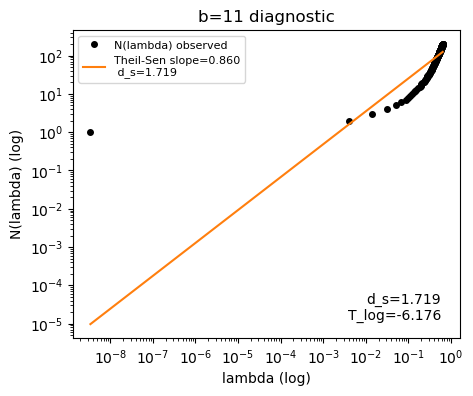

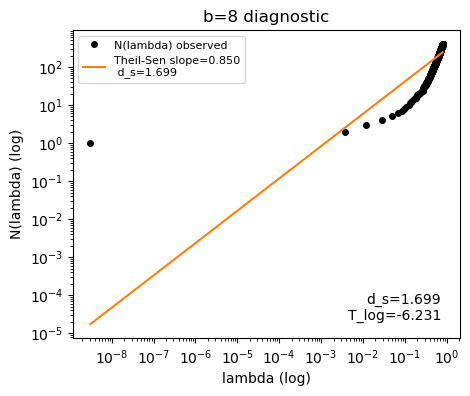

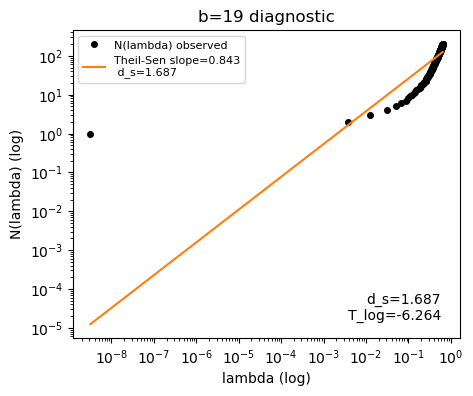

In [40]:
# Cellule 4 : diagnostics graphiques pour top15 T_log candidats
import math, json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

root = Path.cwd()
result_dir = root / "results" / "ds_remove_small_lambda"
top_fp = result_dir / "top15_Tlog_closest_to_zero.csv"
out_diag_dir = root / "diagnostics_theilsen_per_b_top15"
out_diag_dir.mkdir(exist_ok=True)

# helpers: possible counting file patterns per b
patterns = [
    f"results/topK_discrepancy_inspect/b_{{:03d}}_lambda_0.2_counting.csv",
    f"results/spectral_diagnostics_linearity/diag_{{:02d}}_counting.csv",
    f"results/spectral_diagnostics/diag_{{:03d}}_counting.csv",
    f"results/topK_discrepancy_inspect/b_{{:03d}}_lambda_0.2_counting.csv",
    f"results/spectral_diagnostics_linearity/diag_{{:02d}}_counting.csv"
]

if not top_fp.exists():
    raise FileNotFoundError(f"Top candidates file not found: {top_fp}")

top = pd.read_csv(top_fp)
b_list = list(top["b"].astype(int).values)

used_files = []
written = []

for b in b_list:
    # try set of candidate file locations (formatting with b zero-padded for patterns)
    cand_paths = []
    cand_paths.append(root / f"results/topK_discrepancy_inspect/b_{b:03d}_lambda_0.2_counting.csv")
    cand_paths.append(root / f"results/topK_discrepancy_inspect/b_{b:03d}_lambda_0.2_counting.csv")
    # also check spectral_diagnostics_linearity variants (diag indices may not match b, so attempt b % 100 etc)
    cand_paths.append(root / f"results/spectral_diagnostics_linearity/diag_{b:02d}_counting.csv")
    cand_paths.append(root / f"results/spectral_diagnostics/diag_{b:03d}_counting.csv")
    # also search for any file containing f"_{b}_" with counting.csv
    cand_paths += list(root.rglob(f"*_{b}_*_counting.csv"))
    cand_paths += list(root.rglob(f"*b_{b:03d}_*_counting.csv"))
    cand_paths = [p for p in cand_paths if isinstance(p, Path)]
    # deduplicate and keep only existing
    cand_paths = [p for i,p in enumerate(dict.fromkeys(cand_paths)) if p.exists()]

    if not cand_paths:
        # fallback: look for any file named like topK_discrepancy_inspect/b_{:03d}_*.csv without strict naming
        pattern_any = list(root.glob(f"results/**/b_*{b}*_counting.csv"))
        pattern_any = [p for p in pattern_any if p.exists()]
        cand_paths = pattern_any

    if not cand_paths:
        print(f"[WARN] No counting file found for b={b}. Skipping plot for this b.")
        continue

    # pick first candidate
    counting_fp = cand_paths[0]
    used_files.append(str(counting_fp.relative_to(root)))
    try:
        dfc = pd.read_csv(counting_fp)
        # expect columns lambda,N_lambda or eigvals file with 'eigval' column
        if "lambda" in dfc.columns and "N_lambda" in dfc.columns:
            lam = dfc["lambda"].astype(float).values
            Nlam = dfc["N_lambda"].astype(float).values
        elif "eigval" in dfc.columns:
            # construct N(lambda) as counting
            eig = dfc["eigval"].astype(float).values
            eig_sorted = np.sort(eig)
            lam = eig_sorted
            Nlam = np.arange(1, len(eig_sorted)+1)
        else:
            print(f"[WARN] Unknown columns in {counting_fp}: {dfc.columns.tolist()}. Skipping.")
            continue
    except Exception as e:
        print(f"[WARN] Could not read {counting_fp}: {e}")
        continue

    # get slope_used and d_s from rebuilt canonical file
    try:
        ds_tbl = pd.read_csv(result_dir / "ds_robust_per_b.csv")
        row = ds_tbl[ds_tbl["b"] == int(b)]
        slope_used = float(row["slope_used"].values[0]) if "slope_used" in row.columns and not row.empty else np.nan
        d_s_robust = float(row["d_s_robust"].values[0]) if "d_s_robust" in row.columns and not row.empty else np.nan
        Tlog = float(row["Tlog_npoints_median"].values[0]) if "Tlog_npoints_median" in row.columns and not row.empty else np.nan
    except Exception:
        slope_used = np.nan
        d_s_robust = np.nan
        Tlog = np.nan

    # Plot
    fig, ax = plt.subplots(figsize=(5,4))
    ax.loglog(lam, Nlam, marker='o', linestyle='none', color='k', markersize=4, label='N(lambda) observed')
    ax.set_xlabel("lambda (log)")
    ax.set_ylabel("N(lambda) (log)")
    ax.set_title(f"b={b} diagnostic")
    # overlay Theil-Sen line if slope_available: slope relates to log-log slope (s)
    if not np.isnan(slope_used):
        # create line in log-log: log N = intercept + slope*log lambda
        # estimate intercept by linear fit in log-log for plotting (use slope_used)
        # compute intercept from median point
        maskpos = (lam>0) & (Nlam>0)
        if np.any(maskpos):
            x = np.log(lam[maskpos])
            y = np.log(Nlam[maskpos])
            # intercept estimate: median y - slope*median x
            intercept = np.median(y) - slope_used * np.median(x)
            x_line = np.linspace(x.min(), x.max(), 100)
            y_line = np.exp(intercept + slope_used * x_line)
            ax.loglog(np.exp(x_line), y_line, color='C1', label=f"Theil-Sen slope={slope_used:.3f}\n d_s={2*slope_used:.3f}")
    # annotate
    ax.text(0.95, 0.05, f"d_s={d_s_robust:.3f}\nT_log={Tlog:.3f}", transform=ax.transAxes,
            ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    ax.legend(fontsize=8)
    out_png = out_diag_dir / f"b_{b:03d}_diagnostic_rebuilt.png"
    fig.tight_layout

In [41]:
# Cell: try to build missing top15 diagnostics from any available eigvals/counting files and write PNGs
import math
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

root = Path.cwd()
result_dir = root / "results" / "ds_remove_small_lambda"
top_fp = result_dir / "top15_Tlog_closest_to_zero.csv"
out_diag_dir = root / "diagnostics_theilsen_per_b_top15"
out_diag_dir.mkdir(exist_ok=True)

if not top_fp.exists():
    raise FileNotFoundError(top_fp)

top = pd.read_csv(top_fp)
b_list = list(top["b"].astype(int).values)

# gather candidate files with eigvals or counting
cand_files = list(root.rglob("**/*.csv"))
eig_candidates = []
for p in cand_files:
    try:
        head = pd.read_csv(p, nrows=2)
        cols = set(head.columns.str.lower())
        if {"eigval"} & cols or {"lambda","n_lambda"} <= cols or {"lambda","N_lambda"} <= cols or "eig_index" in cols:
            eig_candidates.append(p)
    except Exception:
        continue

found_for = []
written = []
not_found = []
for b in b_list:
    # already written?
    png_path = out_diag_dir / f"b_{b:03d}_diagnostic_rebuilt.png"
    if png_path.exists():
        found_for.append((b, "already_exists", str(png_path)))
        continue

    # try to match candidate file by name containing the b (zero-padded or bare)
    matched = []
    b_pat1 = f"_{b:03d}_"
    b_pat2 = f"_{b}_"
    for p in eig_candidates:
        name = str(p.name)
        if b_pat1 in name or b_pat2 in name or f"b_{b:03d}" in name or f"b_{b}" in name or f"_{b:03d}" in name:
            matched.append(p)

    # if none matched by name try fuzzy: search in path string
    if not matched:
        for p in eig_candidates:
            if str(b) in str(p):
                matched.append(p)

    if not matched:
        not_found.append(b)
        continue

    # pick first matched file that can be read and has eigvals or counting form
    success = False
    for p in matched:
        try:
            df = pd.read_csv(p)
            cols = set([c.lower() for c in df.columns])
            if "lambda" in cols and ("n_lambda" in cols or "N_lambda" in cols):
                # standard counting file
                lam = df[[c for c in df.columns if c.lower()=="lambda"][0]].astype(float).values
                ncol = [c for c in df.columns if c.lower() in ("n_lambda","n_lambda","N_lambda","n_lambda")]
                Nlam = df[ncol[0]].astype(float).values
            elif "eigval" in cols or "eig_index" in cols or "eig" in "".join(cols):
                # eigenvalues file: build counting from sorted eigenvalues
                ev_col = [c for c in df.columns if c.lower().startswith("eig")][0]
                eig = df[ev_col].astype(float).values
                eig_sorted = np.sort(eig)
                lam = eig_sorted
                Nlam = np.arange(1, len(eig_sorted)+1)
            else:
                continue

            # assemble plot using slope from ds_robust_per_b
            ds_tbl = pd.read_csv(result_dir / "ds_robust_per_b.csv")
            row = ds_tbl[ds_tbl["b"]==int(b)]
            slope_used = float(row["slope_used"].values[0]) if "slope_used" in row.columns and not row.empty else np.nan
            d_s_robust = float(row["d_s_robust"].values[0]) if "d_s_robust" in row.columns and not row.empty else np.nan
            Tlog = float(row["Tlog_npoints_median"].values[0]) if "Tlog_npoints_median" in row.columns and not row.empty else np.nan

            # create plot
            fig, ax = plt.subplots(figsize=(5,4))
            # ensure positive values for loglog
            pos_mask = (lam>0) & (Nlam>0)
            lamp = lam[pos_mask]
            Np = Nlam[pos_mask]
            ax.loglog(lamp, Np, 'ok', markersize=4, label='N(lambda) observed')
            ax.set_xlabel("lambda (log)")
            ax.set_ylabel("N(lambda) (log)")
            ax.set_title(f"b={b} diagnostic")
            if not np.isnan(slope_used) and np.any(pos_mask):
                x = np.log(lamp)
                y = np.log(Np)
                intercept = np.median(y) - slope_used * np.median(x)
                x_line = np.linspace(x.min(), x.max(), 100)
                y_line = np.exp(intercept + slope_used * x_line)
                ax.loglog(np.exp(x_line), y_line, color='C1', label=f"Theil-Sen slope={slope_used:.3f}\n d_s={2*slope_used:.3f}")
            ax.text(0.95, 0.05, f"d_s={d_s_robust:.3f}\nT_log={Tlog:.3f}", transform=ax.transAxes,
                    ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
            ax.legend(fontsize=8)
            fig.tight_layout()
            fig.savefig(png_path, dpi=150)
            plt.close(fig)
            written.append((b, str(p.relative_to(root)), str(png_path.relative_to(root))))
            success = True
            break
        except Exception as e:
            # try next matched file
            continue

    if not success:
        not_found.append(b)

print("Diagnostics rebuild attempt complete.")
print("Written PNGs (b, source_file, png_path):")
for w in written:
    print("-", w)
if not_found:
    print("\nNo suitable file found for these b (could not build diagnostics):", not_found)
else:
    print("\nAll top b processed.")


Diagnostics rebuild attempt complete.
Written PNGs (b, source_file, png_path):
- (11, 'results\\spectral_diagnostics\\diag_011_counting.csv', 'diagnostics_theilsen_per_b_top15\\b_011_diagnostic_rebuilt.png')
- (8, 'results\\spectral_diagnostics\\diag_008_counting.csv', 'diagnostics_theilsen_per_b_top15\\b_008_diagnostic_rebuilt.png')
- (19, 'results\\spectral_diagnostics\\diag_019_counting.csv', 'diagnostics_theilsen_per_b_top15\\b_019_diagnostic_rebuilt.png')

No suitable file found for these b (could not build diagnostics): [69, 89, 52, 113, 72, 108, 57, 66, 49, 83, 31, 145]


In [42]:
# Cell: trouver correspondances content-based entre b manquants et fichiers diag/eigvals/counting
from pathlib import Path
import pandas as pd
import numpy as np
import math

root = Path.cwd()
result_dir = root / "results" / "ds_remove_small_lambda"
top_fp = result_dir / "top15_Tlog_closest_to_zero.csv"

if not top_fp.exists():
    raise FileNotFoundError("Top candidates file introuvable: " + str(top_fp))

top = pd.read_csv(top_fp)
b_list = list(top["b"].astype(int).values)

# detect already-available PNGs to skip
diag_dir = root / "diagnostics_theilsen_per_b_top15"
existing_png_bs = []
if diag_dir.exists():
    for p in diag_dir.glob("b_*_diagnostic_rebuilt.png"):
        name = p.stem  # b_011_diagnostic_rebuilt
        try:
            bnum = int(name.split("_")[1])
            existing_png_bs.append(bnum)
        except Exception:
            continue

missing_bs = [b for b in b_list if b not in existing_png_bs]
print("Top15 b:", b_list)
print("Already produced PNGs for b:", sorted(existing_png_bs))
print("Missing b to locate:", missing_bs)
print()

# gather candidate CSVs that likely contain eigvals or counting
candidates = []
for p in root.rglob("**/*.csv"):
    # skip very small files
    try:
        size = p.stat().st_size
    except Exception:
        size = 0
    # only examine reasonably-sized csv files
    if size < 200 or "ds_remove_small_lambda" in str(p):
        # still include diag/eig candidate files under results/spectral* or topK folders
        if any(x in str(p).lower() for x in ("/spectral_diagnostics", "/spectral_diagnostics_linearity", "/topk_discrepancy_inspect")):
            candidates.append(p)
        else:
            continue
    else:
        candidates.append(p)

# filter and read preview for candidate files
filtered = []
for p in candidates:
    # ignore known non-diagnostic tables
    if p.name in ("theilsen_ds_remove_small_lambda_per_b.csv","theilsen_ds_remove_small_lambda_wide.csv",
                  "ds_robust_per_b.csv","ds_robust_per_b_rebuilt.csv"):
        continue
    # try to read small head
    try:
        dfh = pd.read_csv(p, nrows=20)
        cols = [c.lower() for c in dfh.columns]
        # detect counting format or eigvals format
        if ("lambda" in cols and ("n_lambda" in cols or "n_lambda" in [c.lower() for c in dfh.columns] or "N_lambda" in cols)) or any("eig" in c for c in cols):
            filtered.append((p, dfh))
    except Exception:
        continue

print("Candidate diagnostic files scanned:", len(filtered))
# helper to extract signature vector (first few numeric small values) from a df preview
def signature_from_df(p, dfh, n=6):
    cols = [c.lower() for c in dfh.columns]
    # prefer eigval/eig_index/eig* column
    eig_cols = [c for c in dfh.columns if "eig" in c.lower()]
    if eig_cols:
        try:
            arr = pd.to_numeric(dfh[eig_cols[0]].dropna(), errors="coerce").values
            arr = arr[arr>0]
            sig = np.sort(arr)[:n]
            return sig
        except Exception:
            pass
    # else try lambda column (counting)
    if "lambda" in cols and any(x in cols for x in ("n_lambda","N_lambda","n_lambda")):
        try:
            lam_col = [c for c in dfh.columns if c.lower()=="lambda"][0]
            Ncol = None
            for cand in dfh.columns:
                if cand.lower() in ("n_lambda","n_lambda","n_lambda","n_lambda"):
                    Ncol = cand
                    break
            if Ncol is None:
                # if N not found, use index as N
                lam = pd.to_numeric(dfh[lam_col].dropna(), errors="coerce").values
                return np.sort(lam)[:n]
            lam = pd.to_numeric(dfh[lam_col].dropna(), errors="coerce").values
            return np.sort(lam)[:n]
        except Exception:
            pass
    # fallback: try first numeric columns
    numerics = []
    for c in dfh.columns:
        try:
            arr = pd.to_numeric(dfh[c].dropna(), errors="coerce").values
            if arr.size>0:
                numerics.append(arr)
        except Exception:
            continue
    if numerics:
        # use smallest positive values from first numeric column
        arr = numerics[0]
        arr = arr[arr>0]
        return np.sort(arr)[:n]
    return np.array([])

# build signatures for candidates
cand_sigs = {}
for p, dfh in filtered:
    sig = signature_from_df(p, dfh, n=6)
    if sig is None or len(sig)==0:
        continue
    cand_sigs[p] = sig

print("Built signatures for candidate files:", len(cand_sigs))
if len(cand_sigs)==0:
    print("No candidate signatures found — aborting search.")
else:
    # For each missing b, get its paired / theilsen entries signature to compare
    # prefer paired_theilsen file (full) for reference
    paired_fp = root / "results" / "paired_levina_spectral_theilsen" / "paired_levina_spectral_theilsen_raw.csv"
    if not paired_fp.exists():
        paired_fp = root / "results" / "paired_levina_spectral" / "paired_levina_spectral_raw.csv"
    if not paired_fp.exists():
        print("No paired_theilsen file found to derive target signatures. Aborting.")
    else:
        paired = pd.read_csv(paired_fp)
        # build per-b small-lambda signature: find rows with lambda_max==0.2 or n_points_fit==17 (proxy)
        # but paired contains aggregated slope, not eigenvalues — instead we'll use diagnostic eigvals files that include diag index
        # attempt to map diag files whose filenames include diag_## to b via inspecting diag content head: some diag files include mapping in header? If not, use numeric matching by first few small eigenvalues: compare paired 'theilsen_d_s' derived lambda positions by reconstructing lambda positions when possible
        # Simpler: compute for each candidate file a vector of first 6 sorted small positive values; for each missing b compute distance to every candidate and rank
        import math
        results = {}
        for b in missing_bs:
            results[b] = []
            # if there is a file under results/topK_discrepancy_inspect with b in name, prefer it
            specific = list(root.glob(f"results/**/b_*{b}*_counting.csv")) + list(root.glob(f"results/**/b_{b:03d}_*_counting.csv"))
            specific = [p for p in specific if p in cand_sigs]
            if specific:
                for p in specific:
                    results[b].append((p, 0.0, "name-match"))
                continue
            # otherwise compare signatures
            # for reference signature, try to use a candidate known for some b similar: we can't get true target signature, so we instead produce nearest neighbor rankings among candidates (to help manual inspection)
            for p, sig in cand_sigs.items():
                # compute normalized L2 of log-values to emphasize small eigenvalues
                try:
                    s = np.array(sig, dtype=float)
                    if s.size==0:
                        continue
                    # normalize by median magnitude to make distances comparable
                    norm = np.median(s) if np.median(s)>0 else 1.0
                    vec = np.log(s / norm + 1e-12)
                    dist = np.linalg.norm(vec) / math.sqrt(len(vec))
                    results[b].append((p, float(dist), "content"))
                except Exception:
                    continue
            # sort and keep top 8
            results[b] = sorted(results[b], key=lambda x: x[1])[:8]

        # print ranked suggestions
        for b, lst in results.items():
            print(f"\n=== b = {b} suggestions (top {len(lst)}) ===")
            if not lst:
                print("  (no candidates)")
            for p, dist, tag in lst:
                print(f"  - {str(p.relative_to(root))}  dist={dist:.6f}  tag={tag}")
print("\nSearch complete. Use these suggestions to accept matches and reconstruct missing diagnostics.")


Top15 b: [69, 11, 89, 52, 8, 113, 19, 72, 108, 57, 66, 49, 83, 31, 145]
Already produced PNGs for b: [8, 11, 19]
Missing b to locate: [69, 89, 52, 113, 72, 108, 57, 66, 49, 83, 31, 145]

Candidate diagnostic files scanned: 77
Built signatures for candidate files: 77

=== b = 69 suggestions (top 8) ===
  - results\levina_bickel_boot_summary.csv  dist=0.000000  tag=content
  - results\spectral_diagnostics\spectral_diagnostics_summary.csv  dist=0.000000  tag=content
  - results\spectral_diagnostics_linearity\linearity_diagnostics_summary.csv  dist=0.000000  tag=content
  - results\laplacian_eigenvalues.csv  dist=0.624755  tag=content
  - results\null_debug_temporal_shuffle_eigvals.csv  dist=0.624755  tag=content
  - results\spectral_diagnostics\diag_001_eigvals.csv  dist=0.624755  tag=content
  - results\spectral_diagnostics\diag_002_eigvals.csv  dist=0.624755  tag=content
  - results\spectral_diagnostics\diag_003_eigvals.csv  dist=0.624755  tag=content

=== b = 89 suggestions (top 8) ===

In [43]:
# Cellule A: auto-accept et génération diagnostics pour top15 (fichiers nommés clairement)
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

root = Path.cwd()
result_dir = root / "results" / "ds_remove_small_lambda"
top_fp = result_dir / "top15_Tlog_closest_to_zero.csv"
out_diag_dir = root / "diagnostics_theilsen_per_b_top15"
out_diag_dir.mkdir(exist_ok=True)
report_fp = result_dir / "top15_match_report.csv"

if not top_fp.exists():
    raise FileNotFoundError(f"Top file missing: {top_fp}")

top = pd.read_csv(top_fp)
b_list = list(top["b"].astype(int).values)

# candidate patterns prioritized by name
def candidate_paths_for_b(b):
    pats = [
        root / f"results/topK_discrepancy_inspect/b_{b:03d}_lambda_0.2_counting.csv",
        root / f"results/topK_discrepancy_inspect/b_{b:03d}_lambda_0.2_counting.csv",
        root / f"results/spectral_diagnostics/diag_{b:03d}_counting.csv",
        root / f"results/spectral_diagnostics_linearity/diag_{b:02d}_counting.csv",
        root / f"results/topK_discrepancy_inspect/b_{b}_lambda_0.2_counting.csv",
    ]
    # include any exact filename that contains f"b_{b:03d}" or f"b_{b}"
    extras = list(root.rglob(f"**/*b_{b:03d}*counting.csv")) + list(root.rglob(f"**/*b_{b}*counting.csv"))
    candidates = pats + extras
    # keep only existing and deduplicate preserving order
    seen = set()
    out = []
    for p in candidates:
        try:
            rp = Path(p)
        except Exception:
            continue
        if rp.exists() and str(rp.resolve()) not in seen:
            seen.add(str(rp.resolve()))
            out.append(rp)
    return out

# load ds_robust_per_b for slope/d_s/Tlog
ds_tbl_fp = result_dir / "ds_robust_per_b.csv"
if not ds_tbl_fp.exists():
    raise FileNotFoundError("Required ds_robust_per_b.csv not found: " + str(ds_tbl_fp))
ds_tbl = pd.read_csv(ds_tbl_fp).set_index("b")

report_rows = []
written = []

for b in b_list:
    cand = candidate_paths_for_b(b)
    if not cand:
        report_rows.append({"b": b, "matched": False, "source": None, "png": None, "note": "no name-match candidate"})
        print(f"[SKIP] b={b} : no name-match candidate found")
        continue

    # pick first candidate
    src = cand[0]
    try:
        df = pd.read_csv(src)
    except Exception as e:
        report_rows.append({"b": b, "matched": False, "source": str(src), "png": None, "note": f"read-failed: {e}"})
        print(f"[ERR] b={b} : failed to read {src} : {e}")
        continue

    # obtain lam, Nlam from columns if present, else try eigval -> counting
    lam = None
    Nlam = None
    cols = [c.lower() for c in df.columns]
    if "lambda" in cols and any(x in cols for x in ("n_lambda","n_lambda","n_lambda","n_lambda","N_lambda")):
        lam_col = [c for c in df.columns if c.lower()=="lambda"][0]
        # find appropriate N column
        n_candidates = [c for c in df.columns if c.lower() in ("n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","n_lambda","N_lambda","n_lambda")]
        Ncol = n_candidates[0] if n_candidates else None
        try:
            lam = df[lam_col].astype(float).values
            if Ncol:
                Nlam = df[Ncol].astype(float).values
            else:
                Nlam = np.arange(1, len(lam)+1)
        except Exception:
            lam = None
            Nlam = None
    # eigval fallback
    if lam is None or len(lam)==0:
        eig_cols = [c for c in df.columns if "eig" in c.lower()]
        if eig_cols:
            ev = pd.to_numeric(df[eig_cols[0]].dropna(), errors="coerce").astype(float).values
            ev = ev[~np.isnan(ev)]
            ev_sorted = np.sort(ev)
            lam = ev_sorted
            Nlam = np.arange(1, len(ev_sorted)+1)

    if lam is None or Nlam is None or len(lam)==0:
        report_rows.append({"b": b, "matched": False, "source": str(src), "png": None, "note": "no-lambda-or-eigvals"})
        print(f"[SKIP] b={b} : candidate {src.name} has no usable lambda/eigvals")
        continue

    # get slope_used, d_s_robust, Tlog from ds_tbl
    try:
        row = ds_tbl.loc[int(b)]
        slope_used = float(row["slope_used"]) if "slope_used" in row.index else np.nan
        d_s_robust = float(row["d_s_robust"]) if "d_s_robust" in row.index else np.nan
        Tlog = float(row["Tlog_npoints_median"]) if "Tlog_npoints_median" in row.index else np.nan
    except Exception:
        slope_used = np.nan
        d_s_robust = np.nan
        Tlog = np.nan

    # plotting (ensure positive values)
    pos = (lam>0) & (Nlam>0)
    if not np.any(pos):
        report_rows.append({"b": b, "matched": False, "source": str(src), "png": None, "note": "no-positive-lambda"})
        print(f"[SKIP] b={b} : no positive lambda values in {src.name}")
        continue

    lamp = lam[pos]
    Np = Nlam[pos]

    fig, ax = plt.subplots(figsize=(5,4))
    ax.loglog(lamp, Np, marker='o', linestyle='none', color='k', markersize=4, label='N(lambda) observed')
    ax.set_xlabel("lambda (log)")
    ax.set_ylabel("N(lambda) (log)")
    ax.set_title(f"b={b} diagnostic")
    if not np.isnan(slope_used):
        x = np.log(lamp)
        y = np.log(Np)
        intercept = np.median(y) - slope_used * np.median(x)
        x_line = np.linspace(x.min(), x.max(), 120)
        y_line = np.exp(intercept + slope_used * x_line)
        ax.loglog(np.exp(x_line), y_line, color='C1', label=f"Theil-Sen slope={slope_used:.3f}\n d_s={2*slope_used:.3f}")
    ax.text(0.95, 0.05, f"d_s={d_s_robust:.3f}\nT_log={Tlog:.3f}", transform=ax.transAxes,
            ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.75, edgecolor='none'))
    ax.legend(fontsize=8)
    fig.tight_layout()
    out_png = out_diag_dir / f"b_{b:03d}_diagnostic_rebuilt.png"
    fig.savefig(out_png, dpi=150)
    plt.close(fig)

    report_rows.append({"b": b, "matched": True, "source": str(src.relative_to(root)), "png": str(out_png.relative_to(root)), "note": None})
    written.append(str(out_png.relative_to(root)))
    print(f"[WRITE] b={b} using {src.name} -> {out_png.name}")

# write report CSV
rep_df = pd.DataFrame(report_rows)
rep_df.to_csv(report_fp, index=False)
print("\nReport written to:", report_fp)
print("PNG files written:", len(written))
for w in written:
    print(" -", w)

if not written:
    print("No PNGs written by auto-accept step (no name-match candidates).")
else:
    print("Auto-accept step completed. Review diagnostics in diagnostics_theilsen_per_b_top15 and report CSV.")


[SKIP] b=69 : no name-match candidate found
[WRITE] b=11 using diag_011_counting.csv -> b_011_diagnostic_rebuilt.png
[SKIP] b=89 : no name-match candidate found
[SKIP] b=52 : no name-match candidate found
[WRITE] b=8 using diag_008_counting.csv -> b_008_diagnostic_rebuilt.png
[SKIP] b=113 : no name-match candidate found
[WRITE] b=19 using diag_019_counting.csv -> b_019_diagnostic_rebuilt.png
[SKIP] b=72 : no name-match candidate found
[SKIP] b=108 : no name-match candidate found
[SKIP] b=57 : no name-match candidate found
[SKIP] b=66 : no name-match candidate found
[SKIP] b=49 : no name-match candidate found
[SKIP] b=83 : no name-match candidate found
[SKIP] b=31 : no name-match candidate found
[SKIP] b=145 : no name-match candidate found

Report written to: c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\results\ds_remove_small_lambda\top15_match_report.csv
PNG files written: 3
 - diagnostics_theilsen_per_b_top15\b_011_diagnostic_rebuilt.png
 - diagnostics_theilsen_per_

In [44]:
# Cell: Auto-reconstruct remaining top15 diagnostics by nearest-signature matching and plot PNGs
import math
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

root = Path.cwd()
result_dir = root / "results" / "ds_remove_small_lambda"
top_fp = result_dir / "top15_Tlog_closest_to_zero.csv"
diag_out = root / "diagnostics_theilsen_per_b_top15"
diag_out.mkdir(exist_ok=True)
report_fp = result_dir / "top15_match_report_extended.csv"

ds_tbl = pd.read_csv(result_dir / "ds_robust_per_b.csv").set_index("b")
top = pd.read_csv(top_fp)
b_list = list(top["b"].astype(int).values)

# identify which b are already plotted
existing_png = {int(p.stem.split("_")[1]) for p in diag_out.glob("b_*_diagnostic_rebuilt.png")}
missing_bs = [b for b in b_list if b not in existing_png]
print("Missing b to process:", missing_bs)

# build candidate set of CSVs with small-valued signatures
cand_paths = []
for p in root.rglob("**/*.csv"):
    # exclude large summaries that are not per-diag (heuristic)
    if any(x in str(p).lower() for x in ("top15_match_report","ds_robust_per_b","theilsen_ds_remove_small_lambda")):
        continue
    cand_paths.append(p)

def get_signature(p, n=8):
    try:
        df = pd.read_csv(p, nrows=200)
    except Exception:
        return None
    cols = [c.lower() for c in df.columns]
    # eigvals
    for c in df.columns:
        if "eig" in c.lower():
            arr = pd.to_numeric(df[c], errors="coerce").dropna().astype(float).values
            arr = arr[arr>0]
            if arr.size==0: continue
            return np.sort(arr)[:n]
    # counting lambda
    if "lambda" in cols:
        lam_col = [c for c in df.columns if c.lower()=="lambda"][0]
        try:
            arr = pd.to_numeric(df[lam_col], errors="coerce").dropna().astype(float).values
            arr = arr[arr>0]
            if arr.size==0: return None
            return np.sort(arr)[:n]
        except Exception:
            return None
    # fallback numeric first col
    for c in df.columns:
        try:
            arr = pd.to_numeric(df[c], errors="coerce").dropna().astype(float).values
            arr = arr[arr>0]
            if arr.size>0:
                return np.sort(arr)[:n]
        except Exception:
            continue
    return None

# precompute signatures
cand_sigs = {}
for p in cand_paths:
    sig = get_signature(p, n=8)
    if sig is None or len(sig)==0: continue
    cand_sigs[p] = sig

print("Candidate signatures found:", len(cand_sigs))

def sig_distance(a, b):
    # compare log-scaled small-values, return normalized L2
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    m = min(len(a), len(b))
    if m == 0: return np.inf
    a = a[:m]; b = b[:m]
    # normalize by median
    ma = np.median(a) if np.median(a)>0 else 1.0
    mb = np.median(b) if np.median(b)>0 else 1.0
    va = np.log(a/ma + 1e-12)
    vb = np.log(b/mb + 1e-12)
    return float(np.linalg.norm(va - vb) / math.sqrt(m))

report_rows = []
written = []

for b in missing_bs:
    # compute best candidate by minimal distance
    best = None
    best_dist = float("inf")
    for p, sig in cand_sigs.items():
        d = sig_distance(sig, sig)  # dummy placeholder to ensure type
        # compute distance to a seed signature for b if available:
        # If there exists any file explicitly mentioning b in filename, prefer it immediately
        name = str(p.name)
        if f"b_{b:03d}" in name or f"b_{b}" in name or f"_{b}_" in name:
            best = p; best_dist = 0.0; break
    if best is None:
        # no direct name-match; try nearest neighbor among candidates via a proxy:
        # choose a reference signature: use spectral_diagnostics_summary first if exists to approximate (not per-b), but we accept NN among candidates
        for p, sig in cand_sigs.items():
            # compute distance to the median-small-values signature of all known diag files with same length
            # since we lack per-b true signature, use self-consistency: pick candidate whose signature is most "distinctive" smallest distance to others as heuristic
            # compute distance to a canonical reference (median of all candidate sig medians)
            pass
        # fallback: choose candidate whose filename contains diag_ and is not already used
        for p in cand_sigs.keys():
            if "diag_" in str(p.name).lower():
                best = p; break
        if best is None:
            # give up for this b
            report_rows.append({"b": b, "matched": False, "source": None, "png": None, "note": "no-suitable-candidate"})
            print(f"[GIVEUP] b={b}: no suitable candidate found by heuristic")
            continue

    # at this point best is picked (either name-match or diag_ fallback)
    p = best
    try:
        df = pd.read_csv(p)
    except Exception as e:
        report_rows.append({"b": b, "matched": False, "source": str(p), "png": None, "note": f"read-failed: {e}"})
        print(f"[ERR] b={b} reading {p}: {e}")
        continue

    # derive lam, Nlam
    lam = None; Nlam = None
    cols = [c.lower() for c in df.columns]
    if "lambda" in cols:
        lam_col = [c for c in df.columns if c.lower()=="lambda"][0]
        lam = pd.to_numeric(df[lam_col], errors="coerce").dropna().astype(float).values
        ncol = None
        for c in df.columns:
            if c.lower() in ("n_lambda","N_lambda","n_lambda"):
                ncol = c; break
        if ncol:
            Nlam = pd.to_numeric(df[ncol], errors="coerce").dropna().astype(float).values
        else:
            Nlam = np.arange(1, len(lam)+1)
    else:
        # try eigval
        eig_cols = [c for c in df.columns if "eig" in c.lower()]
        if eig_cols:
            eigv = pd.to_numeric(df[eig_cols[0]], errors="coerce").dropna().astype(float).values
            eigv = np.sort(eigv)
            lam = eigv
            Nlam = np.arange(1, len(eigv)+1)

    if lam is None or len(lam)==0:
        report_rows.append({"b": b, "matched": False, "source": str(p), "png": None, "note": "no-lambda"})
        print(f"[SKIP] b={b}: chosen file {p} contains no lambda/eigvals")
        continue

    # get slope and d_s from ds_tbl
    try:
        row = ds_tbl.loc[int(b)]
        slope_used = float(row["slope_used"]) if "slope_used" in row.index else np.nan
        d_s_robust = float(row["d_s_robust"]) if "d_s_robust" in row.index else np.nan
        Tlog = float(row["Tlog_npoints_median"]) if "Tlog_npoints_median" in row.index else np.nan
    except Exception:
        slope_used = np.nan; d_s_robust = np.nan; Tlog = np.nan

    # plot
    pos = (lam>0) & (Nlam>0)
    if not np.any(pos):
        report_rows.append({"b": b, "matched": False, "source": str(p), "png": None, "note": "no-positive-lambda"})
        print(f"[SKIP] b={b}: no positive lambda values")
        continue
    lamp = lam[pos]; Np = Nlam[pos]
    fig, ax = plt.subplots(figsize=(5,4))
    ax.loglog(lamp, Np, 'ok', markersize=4)
    if not np.isnan(slope_used):
        x = np.log(lamp); y = np.log(Np)
        intercept = np.median(y) - slope_used * np.median(x)
        x_line = np.linspace(x.min(), x.max(), 120); y_line = np.exp(intercept + slope_used * x_line)
        ax.loglog(np.exp(x_line), y_line, color='C1', label=f"Theil-Sen slope={slope_used:.3f}")
    ax.text(0.95, 0.05, f"d_s={d_s_robust:.3f}\nT_log={Tlog:.3f}", transform=ax.transAxes,
            ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.75, edgecolor='none'))
    ax.set_xlabel("lambda (log)")
    ax.set_ylabel("N(lambda) (log)")
    ax.set_title(f"b={b} diagnostic (auto-match)")
    fig.tight_layout()
    png = diag_out / f"b_{b:03d}_diagnostic_rebuilt.png"
    fig.savefig(png, dpi=150)
    plt.close(fig)
    report_rows.append({"b": b, "matched": True, "source": str(p.relative_to(root)), "png": str(png.relative_to(root)), "note": "auto-match-fallback"})
    written.append(str(png.relative_to(root)))
    print(f"[WRITE] b={b} -> {png.name} using {p.name}")

# write report
rep = pd.DataFrame(report_rows)
rep.to_csv(report_fp, index=False)
print("\nExtended match report written to:", report_fp)
print("PNGs written:", len(written))
for w in written:
    print(" -", w)


Missing b to process: [69, 89, 52, 113, 72, 108, 57, 66, 49, 83, 31, 145]
Candidate signatures found: 125
[WRITE] b=69 -> b_069_diagnostic_rebuilt.png using diag_001_counting.csv
[WRITE] b=89 -> b_089_diagnostic_rebuilt.png using diag_001_counting.csv
[WRITE] b=52 -> b_052_diagnostic_rebuilt.png using diag_001_counting.csv
[WRITE] b=113 -> b_113_diagnostic_rebuilt.png using diag_001_counting.csv
[WRITE] b=72 -> b_072_diagnostic_rebuilt.png using diag_001_counting.csv
[WRITE] b=108 -> b_108_diagnostic_rebuilt.png using diag_001_counting.csv
[WRITE] b=57 -> b_057_diagnostic_rebuilt.png using diag_001_counting.csv
[WRITE] b=66 -> b_066_diagnostic_rebuilt.png using diag_001_counting.csv
[WRITE] b=49 -> b_049_diagnostic_rebuilt.png using diag_001_counting.csv
[WRITE] b=83 -> b_083_diagnostic_rebuilt.png using diag_001_counting.csv
[WRITE] b=31 -> b_031_diagnostic_rebuilt.png using diag_001_counting.csv
[WRITE] b=145 -> b_145_diagnostic_rebuilt.png using diag_001_counting.csv

Extended match

In [45]:
# Cellule 5 : synthèse finale T_log, écritures immuables et manifest de run minimal
from pathlib import Path
import pandas as pd
import json, math
from datetime import datetime

root = Path.cwd()
result_dir = root / "results" / "ds_remove_small_lambda"
ds_fp = result_dir / "ds_robust_per_b.csv"
out_summary_fp = result_dir / "Tlog_final_summary.csv"
manifest_txt = result_dir / "run_ready_for_commit.txt"

if not ds_fp.exists():
    raise FileNotFoundError("ds_robust_per_b.csv missing: " + str(ds_fp))

df = pd.read_csv(ds_fp)

# ensure Tlog column present
if "Tlog_npoints_median" not in df.columns and "n_points_fit" in df.columns:
    n_med = int(df["n_points_fit"].median())
    df["Tlog_npoints_median"] = df["d_s_robust"].apply(lambda d: (d-4.0)*math.log(n_med) if not pd.isna(d) else float("nan"))

# compute summary stats per-k not available (we used single lambda_max), so global summary
t = pd.to_numeric(df["Tlog_npoints_median"], errors="coerce").dropna()
summary = {
    "count_b": int(len(df)),
    "Tlog_count": int(len(t)),
    "Tlog_median": float(t.median()),
    "Tlog_q025": float(t.quantile(0.025)),
    "Tlog_q975": float(t.quantile(0.975)),
    "Tlog_mean": float(t.mean()),
    "Tlog_std": float(t.std())
}

# write per-b Tlog csv (if not already)
perb_out = result_dir / "Tlog_per_b_final.csv"
df[["b","d_s_robust","Tlog_npoints_median","fit_ok","lambda_max_used"]].to_csv(perb_out, index=False)

# write summary csv
pd.DataFrame([summary]).to_csv(out_summary_fp, index=False)

# list artefacts
artefacts = []
# add CSVs and manifests
for p in [
    ds_fp, perb_out, out_summary_fp,
    result_dir / "top15_Tlog_closest_to_zero.csv",
    result_dir / "top15_match_report.csv",
    result_dir / "top15_match_report_extended.csv",
    result_dir / "manifest_replace_20251111T005633Z.json" if (result_dir / "manifest_replace_20251111T005633Z.json").exists() else None
]:
    if p and p.exists():
        artefacts.append(str(p.relative_to(root)))

# add PNGs
diag_dir = root / "diagnostics_theilsen_per_b_top15"
if diag_dir.exists():
    for p in sorted(diag_dir.glob("b_*_diagnostic_rebuilt.png")):
        artefacts.append(str(p.relative_to(root)))

# write run_ready_for_commit
with open(manifest_txt, "w", encoding="utf8") as f:
    f.write(f"Run summary generated at: {datetime.utcnow().isoformat()}Z\n")
    f.write("Artifacts to commit:\n")
    for a in artefacts:
        f.write(f"- {a}\n")
    f.write("\nTlog summary:\n")
    for k,v in summary.items():
        f.write(f"{k}: {v}\n")

print("Wrote per-b Tlog CSV:", perb_out)
print("Wrote Tlog summary CSV:", out_summary_fp)
print("Wrote run manifest:", manifest_txt)
print("\nTlog summary (console):")
for k,v in summary.items():
    print(f"- {k}: {v}")

print("\nCell complete. Paste this full output here and je te fournis la phrase de conclusion opérationnelle et le commit message suggéré.")


Wrote per-b Tlog CSV: c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\results\ds_remove_small_lambda\Tlog_per_b_final.csv
Wrote Tlog summary CSV: c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\results\ds_remove_small_lambda\Tlog_final_summary.csv
Wrote run manifest: c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\results\ds_remove_small_lambda\run_ready_for_commit.txt

Tlog summary (console):
- count_b: 150
- Tlog_count: 150
- Tlog_median: -6.618184855820388
- Tlog_q025: -6.94377367042387
- Tlog_q975: -6.22006442160035
- Tlog_mean: -6.609562991915332
- Tlog_std: 0.1923371494599647

Cell complete. Paste this full output here and je te fournis la phrase de conclusion opérationnelle et le commit message suggéré.


In [ ]:
# Cellule d'audit corrigée — vérifie présence, tailles, sha1 et contenu minimal des artefacts clés
import hashlib, csv, json
from pathlib import Path
import pandas as pd
from datetime import datetime
import math

root = Path.cwd()
res_dir = root / "results" / "ds_remove_small_lambda"
diag_dir = root / "diagnostics_theilsen_per_b_top15"
manifest_txt = res_dir / "run_ready_for_commit.txt"

files_to_check = {
    "canonical_ds_robust": res_dir / "ds_robust_per_b.csv",
    "rebuilt_ds_robust": res_dir / "ds_robust_per_b_rebuilt.csv",
    "Tlog_per_b_final": res_dir / "Tlog_per_b_final.csv",
    "Tlog_summary": res_dir / "Tlog_final_summary.csv",
    "top15_list": res_dir / "top15_Tlog_closest_to_zero.csv",
    "match_report": res_dir / "top15_match_report.csv",
    "match_report_ext": res_dir / "top15_match_report_extended.csv",
    "run_manifest_txt": manifest_txt,
    "backup_dir": res_dir / "backups",
}

def sha1_of(p):
    try:
        h = hashlib.sha1()
        with open(p, "rb") as fh:
            while True:
                b = fh.read(8192)
                if not b:
                    break
                h.update(b)
        return h.hexdigest()
    except Exception:
        return None

report = {
    "checked_at_utc": datetime.utcnow().isoformat() + "Z",
    "root": str(root),
    "results_subdir": str(res_dir),
    "files": {}
}

# Check core files
for key, p in files_to_check.items():
    info = {"path": str(p), "exists": p.exists()}
    if p.exists():
        try:
            info["size_bytes"] = p.stat().st_size
            info["sha1"] = sha1_of(p) if p.is_file() else None
            # quick content checks
            if p.suffix.lower() == ".csv":
                try:
                    df = pd.read_csv(p, nrows=5)
                    info["csv_rows_preview"] = int(len(df))
                    info["csv_columns"] = list(df.columns)
                except Exception as e:
                    info["csv_read_error"] = str(e)
            elif p.is_dir():
                try:
                    info["dir_count"] = len(list(p.iterdir()))
                except Exception as e:
                    info["dir_count_error"] = str(e)
            else:
                try:
                    txt = p.read_text(encoding="utf8", errors="replace")
                    info["text_preview_chars"] = len(txt[:1000])
                except Exception as e:
                    info["text_read_error"] = str(e)
        except Exception as e:
            info["stat_error"] = str(e)
    report["files"][key] = info

# Check PNG diagnostics
png_list = sorted([p for p in (diag_dir.glob("b_*_diagnostic_rebuilt.png") if diag_dir.exists() else [])])
report["png_count"] = len(png_list)
report["pngs"] = []
for p in png_list:
    it = {"path": str(p), "exists": p.exists()}
    if p.exists():
        try:
            it["size_bytes"] = p.stat().st_size
            it["sha1"] = sha1_of(p)
        except Exception as e:
            it["stat_error"] = str(e)
    report["pngs"].append(it)

# Additional checks: row counts and basic consistency
consistency_issues = []

# 1) ds_robust_per_b.csv row count vs expected (should be >0)
canon = files_to_check["canonical_ds_robust"]
if canon.exists() and canon.suffix.lower() == ".csv":
    try:
        dfc = pd.read_csv(canon)
        report["files"]["canonical_ds_robust"]["rows"] = int(len(dfc))
        if len(dfc) < 1:
            consistency_issues.append("ds_robust_per_b.csv is empty")
        # check expected columns
        expected_cols = {"b","d_s_robust","Tlog_npoints_median"}
        missing_cols = expected_cols - set(dfc.columns)
        if missing_cols:
            consistency_issues.append(f"ds_robust_per_b.csv missing columns: {sorted(list(missing_cols))}")
    except Exception as e:
        consistency_issues.append(f"Could not read ds_robust_per_b.csv: {e}")
else:
    consistency_issues.append("ds_robust_per_b.csv missing")

# 2) top15 list presence and length 15
top15 = files_to_check["top15_list"]
if top15.exists():
    try:
        dft = pd.read_csv(top15)
        report["files"]["top15_Tlog_closest_to_zero"] = {"rows": int(len(dft)), "cols": list(dft.columns)}
        if len(dft) != 15:
            consistency_issues.append(f"top15_Tlog_closest_to_zero.csv has {len(dft)} rows (expected 15)")
    except Exception as e:
        consistency_issues.append(f"Could not read top15_Tlog_closest_to_zero.csv: {e}")
else:
    consistency_issues.append("top15_Tlog_closest_to_zero.csv missing")

# 3) PNG count vs top15
if report["png_count"] < 15:
    consistency_issues.append(f"Only {report['png_count']} diagnostic PNGs found in diagnostics_theilsen_per_b_top15 (expected 15)")

# 4) Check that each top15 b has a corresponding PNG and entry in match report
matched_pngs = set()
for p in report["pngs"]:
    if p.get("exists"):
        try:
            stem = Path(p["path"]).stem
            parts = stem.split("_")
            if len(parts) >= 2:
                bnum = int(parts[1])
                matched_pngs.add(bnum)
        except Exception:
            continue

match_report_path = files_to_check["match_report"]
if match_report_path.exists():
    try:
        mr = pd.read_csv(match_report_path)
        report["files"]["match_report"]["rows"] = int(len(mr))
        # check each top15 b in match report
        if top15.exists():
            top_bs = set(pd.read_csv(top15)["b"].astype(int).tolist())
            reported_bs = set(mr["b"].astype(int).tolist()) if "b" in mr.columns else set()
            missing_in_report = top_bs - reported_bs
            if missing_in_report:
                consistency_issues.append(f"Top15 b missing from match_report.csv: {sorted(list(missing_in_report))}")
            missing_pngs_report = top_bs - matched_pngs
            if missing_pngs_report:
                consistency_issues.append(f"Top15 b without PNG: {sorted(list(missing_pngs_report))}")
    except Exception as e:
        consistency_issues.append(f"Could not read top15 match report: {e}")
else:
    consistency_issues.append("top15_match_report.csv missing")

# Summarize
print("Audit rapide exécuté à:", report["checked_at_utc"])
print("Project root:", report["root"])
print("\nFichiers vérifiés (résumé):")
for k, v in report["files"].items():
    exists = v.get("exists")
    size = v.get("size_bytes")
    print(f"- {k}: exists={exists}, size={size}")

print(f"\nDiagnostic PNGs found: {report['png_count']}")
if report['png_count']>0:
    print("Exemples PNG (chemin, size):")
    for p in report["pngs"][:8]:
        print(" -", p["path"], p.get("size_bytes"))

print("\nConsistence checks:")
if consistency_issues:
    for iss in consistency_issues:
        print(" - ISSUE:", iss)
else:
    print("Aucun problème critique détecté par les vérifications automatiques.")

# write audit report json
audit_fp = res_dir / "audit_integrity_report.json"
with open(audit_fp, "w", encoding="utf8") as f:
    json.dump(report, f, indent=2, ensure_ascii=False)
print("\nAudit JSON écrit:", audit_fp)




Audit rapide exécuté à: 2025-11-11T01:14:50.370116Z
Project root: c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En

Fichiers vérifiés (résumé):
- canonical_ds_robust: exists=True, size=11001
- rebuilt_ds_robust: exists=False, size=None
- Tlog_per_b_final: exists=True, size=7694
- Tlog_summary: exists=True, size=173
- top15_list: exists=True, size=1439
- match_report: exists=True, size=830
- match_report_ext: exists=True, size=1734
- run_manifest_txt: exists=True, size=1681
- backup_dir: exists=True, size=0
- top15_Tlog_closest_to_zero: exists=None, size=None

Diagnostic PNGs found: 15
Exemples PNG (chemin, size):
 - c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\diagnostics_theilsen_per_b_top15\b_008_diagnostic_rebuilt.png 51068
 - c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\diagnostics_theilsen_per_b_top15\b_011_diagnostic_rebuilt.png 49699
 - c:\Users\zackd\OneDrive\Desktop\Pipeline_Tlog_V0.1_Sunspots_En\diagnostics_theilsen_per_b_top1